# Orbit Propagation Validation Plotting for RMS differences

This tutorial demonstrates how to perform orbit propagation using the propagated orbit mode.

## Setup

In [332]:
import numpy as np
import pandas as pd
import csv
import os

import plotly.graph_objs as go

from ostk.mathematics.geometry.d3.object import Cuboid
from ostk.mathematics.geometry.d3.object import Composite
from ostk.mathematics.geometry.d3.object import Point

from ostk.physics.unit import Mass
from ostk.physics.time import Scale
from ostk.physics.time import Instant
from ostk.physics.time import Duration
from ostk.physics.time import DateTime
from ostk.physics.coordinate import Position
from ostk.physics.coordinate import Velocity
from ostk.physics.coordinate import Frame
from ostk.physics import Environment
from ostk.physics.environment.object.celestial import Earth

from ostk.astrodynamics.trajectory.state import NumericalSolver
from ostk.astrodynamics.trajectory import State
from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics.flight.system import SatelliteSystem
from ostk.astrodynamics.dynamics import SatelliteDynamics
from ostk.astrodynamics.trajectory.orbit.models import Propagated

---

## Propagated Orbit Model

Read in reference data from CSV file 

In [333]:
filename = "STK_EGM2008_100x100NoSecVar_24hr_run.csv"
plot_title_extension = (
    "RMS error for STK with EGM2008 (without secular coeff update) vs OSTk"
)
# legend_name_list = ['OSTk with 30s interval']
legend_name_list = [
    "OSTk EGM2008 100x100 minus STK EGM2008 70x70",
    "OSTk EGM2008 70x70 minus STK EGM2008 70x70",
]

multiplication_array = np.array([1.0e3, 1.0e3, 1.0e3])

start_instant = Instant.date_time(DateTime.parse("2021-03-20T00:00:00.000"), Scale.UTC)
frame_GCRF = Frame.GCRF()

with open(f"{os.getcwd()}/Outputfiles/{filename}", newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    reference_state_array = []
    instant_array = []
    for row in reader:
        instant_iter = start_instant + Duration.seconds(float(row["YAM.ElapsedSecs"]))
        position_iter = Position.meters(
            [row["YAM.EarthICRF.X"], row["YAM.EarthICRF.Y"], row["YAM.EarthICRF.Z"]],
            frame_GCRF,
        )
        velocity_iter = Velocity.meters_per_second(
            [row["YAM.EarthICRF.VX"], row["YAM.EarthICRF.VY"], row["YAM.EarthICRF.VZ"]],
            frame_GCRF,
        )

        position_iter_m = np.multiply(
            position_iter.get_coordinates(), multiplication_array
        )
        velocity_iter_ms = np.multiply(
            velocity_iter.get_coordinates(), multiplication_array
        )

        instant_array.append(instant_iter)
        reference_state_array.append(
            State(
                instant_iter,
                Position.meters(position_iter_m, frame_GCRF),
                Velocity.meters_per_second(velocity_iter_ms, frame_GCRF),
            )
        )

### Computation

Create an environment corresponding to the perturbations that should be used

In [334]:
instant_J2000 = Instant.J2000()

objects_1 = [Earth.EGM96(100, 100)]  # , Sun.spherical(), Moon.spherical()]
objects_2 = [Earth.EGM96(70, 70)]
# objects_3 = [Earth.EGM96(70,70)]
# objects_4 = [Earth.EGM96(35, 35)]

custom_env_1 = Environment(instant_J2000, objects_1)
custom_env_2 = Environment(instant_J2000, objects_2)
# custom_env_3 = Environment(instant_J2000, objects_3)
# custom_env_4 = Environment(instant_J2000, objects_4)

Create multiple satellite system, a satellite dynamical system, and a numerical solver

In [335]:
mass = Mass(90.0, Mass.Unit.Kilogram)
satellite_geometry = Composite(
    Cuboid(
        Point(0.0, 0.0, 0.0),
        [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]],
        [1.0, 0.0, 0.0],
    )
)
inertia_tensor = np.ndarray(shape=(3, 3))
surface_area = 0.8
drag_coefficient = 2.2

satellitesystem = SatelliteSystem(
    mass, satellite_geometry, inertia_tensor, surface_area, drag_coefficient
)

start_state = reference_state_array[0]

satellitedynamics_1 = SatelliteDynamics(custom_env_1, satellitesystem)
satellitedynamics_2 = SatelliteDynamics(custom_env_2, satellitesystem)
# satellitedynamics_3 = SatelliteDynamics(custom_env_3, satellitesystem, start_state)
# satellitedynamics_4 = SatelliteDynamics(custom_env_4, satellitesystem, start_state)

numericalsolver_1 = NumericalSolver(
    NumericalSolver.LogType.NoLog,
    NumericalSolver.StepperType.RungeKuttaFehlberg78,
    5.0,
    1.0e-15,
    1.0e-15,
)
numericalsolver_2 = NumericalSolver(
    NumericalSolver.LogType.NoLog,
    NumericalSolver.StepperType.RungeKuttaFehlberg78,
    5.0,
    1.0e-15,
    1.0e-15,
)
# numericalsolver_3 = NumericalSolver(NumericalSolver.LogType.NoLog, NumericalSolver.StepperType.RungeKuttaFehlberg78, 5.0, 1.0e-15, 1.0e-15)
# numericalsolver_4 = NumericalSolver(NumericalSolver.LogType.NoLog, NumericalSolver.StepperType.RungeKuttaFehlberg78, 5.0, 1.0e-15, 1.0e-15)

# numericalsolver_2 = NumericalSolver(NumericalSolver.LogType.NoLog, NumericalSolver.StepperType.RungeKuttaFehlberg78, 5.0, 1.0e-15, 1.0e-15)

Setup a different Propagated models an an instant array at which propagated states are desired

In [336]:
propagated_model_1 = Propagated(satellitedynamics_1, numericalsolver_1, start_state)
propagated_model_2 = Propagated(satellitedynamics_2, numericalsolver_2, start_state)
# propagated_model_3 = Propagated(satellitedynamics_3, numericalsolver_3)
# propagated_model_4 = Propagated(satellitedynamics_4, numericalsolver_4)

orbit_1 = Orbit(
    propagated_model_1, custom_env_1.access_celestial_object_with_name("Earth")
)
orbit_2 = Orbit(
    propagated_model_2, custom_env_2.access_celestial_object_with_name("Earth")
)
# orbit_3 = Orbit(propagated_model_3, custom_env_3.access_celestial_object_with_name('Earth'))
# orbit_4 = Orbit(propagated_model_4, custom_env_4.access_celestial_object_with_name('Earth'))

orbit_list = [orbit_1, orbit_2]  # , orbit_3]#, orbit_4]

Now that everything is set up, we can calculate the state arrays from the desired time instant grid

In [337]:
propagated_state_array_list = [
    orbit_list[ind].get_states_at(instant_array) for ind in range(0, len(orbit_list))
]

In [338]:
def to_dataframe(propagated_state, ind):
    return [
        repr(propagated_state.get_instant()),
        float(
            (
                propagated_state.get_instant()
                - propagated_state_array_list[ind][0].get_instant()
            ).in_seconds()
        ),
        *propagated_state.get_position().get_coordinates(),
        *propagated_state.get_velocity().get_coordinates(),
    ]

In [339]:
propagated_orbit_data_list = [
    [
        to_dataframe(propagated_state, ind)
        for propagated_state in propagated_state_array_list[ind]
    ]
    for ind in range(0, len(orbit_list))
]

In [340]:
propagated_orbit_df_list = [
    pd.DataFrame(
        propagated_orbit_data_list[ind],
        columns=[
            "$Time^{UTC}$",
            "Elapsed secs",
            "$x_{x}^{ECI}$",
            "$x_{y}^{ECI}$",
            "$x_{z}^{ECI}$",
            "$v_{x}^{ECI}$",
            "$v_{y}^{ECI}$",
            "$v_{z}^{ECI}$",
        ],
    )
    for ind in range(0, len(orbit_list))
]

Table:

In [341]:
[propagated_orbit_df_list[ind].head() for ind in range(0, len(orbit_list))]

[                $Time^{UTC}$  Elapsed secs  $x_{x}^{ECI}$  $x_{y}^{ECI}$  \
 0  2021-03-20 00:00:00 [UTC]           0.0  -1.514669e+06 -192084.121491   
 1  2021-03-20 00:01:00 [UTC]          60.0  -1.892139e+06   40209.643464   
 2  2021-03-20 00:02:00 [UTC]         120.0  -2.261735e+06  272336.347500   
 3  2021-03-20 00:03:00 [UTC]         180.0  -2.621919e+06  503329.886059   
 4  2021-03-20 00:04:00 [UTC]         240.0  -2.971190e+06  732228.560244   
 
    $x_{z}^{ECI}$  $v_{x}^{ECI}$  $v_{y}^{ECI}$  $v_{z}^{ECI}$  
 0   6.831711e+06   -6348.079188    3867.582493   -1297.176104  
 1   6.739684e+06   -6229.875938    3872.857026   -1769.350138  
 2   6.619536e+06   -6085.730799    3862.015054   -2234.203938  
 3   6.471765e+06   -5916.233718    3835.097084   -2689.802878  
 4   6.296983e+06   -5722.080031    3792.209441   -3134.248551  ,
                 $Time^{UTC}$  Elapsed secs  $x_{x}^{ECI}$  $x_{y}^{ECI}$  \
 0  2021-03-20 00:00:00 [UTC]           0.0  -1.514669e+06 -192084.1

In [342]:
[propagated_orbit_df_list[ind].tail() for ind in range(0, len(orbit_list))]

[                   $Time^{UTC}$  Elapsed secs  $x_{x}^{ECI}$  $x_{y}^{ECI}$  \
 1436  2021-03-20 23:56:00 [UTC]       86160.0   6.069746e+06  -3.464214e+06   
 1437  2021-03-20 23:57:00 [UTC]       86220.0   5.992655e+06  -3.490139e+06   
 1438  2021-03-20 23:58:00 [UTC]       86280.0   5.890626e+06  -3.501541e+06   
 1439  2021-03-20 23:59:00 [UTC]       86340.0   5.764077e+06  -3.498368e+06   
 1440  2021-03-21 00:00:00 [UTC]       86400.0   5.613533e+06  -3.480632e+06   
 
       $x_{z}^{ECI}$  $v_{x}^{ECI}$  $v_{y}^{ECI}$  $v_{z}^{ECI}$  
 1436   6.075027e+05   -1075.124079    -552.599779    7441.867643  
 1437   1.052437e+06   -1493.691431    -311.286987    7384.104632  
 1438   1.492979e+06   -1906.129737     -68.628218    7295.514250  
 1439   1.927289e+06   -2310.703179     174.357160    7176.458785  
 1440   2.353554e+06   -2705.708860     416.647785    7027.430444  ,
                    $Time^{UTC}$  Elapsed secs  $x_{x}^{ECI}$  $x_{y}^{ECI}$  \
 1436  2021-03-20 23:56:00 [U

#### Trajectory RMS error vs GMAT run in the GCRF frame 

In [343]:
def to_dataframe_RMS(ref_ind, list_ind):
    return [
        repr(propagated_state_array_list[list_ind][ref_ind].get_instant()),
        float(
            (
                propagated_state_array_list[list_ind][ref_ind].get_instant()
                - propagated_state_array_list[list_ind][0].get_instant()
            ).in_seconds()
        ),
        (
            np.linalg.norm(
                (
                    propagated_state_array_list[list_ind][ref_ind]
                    .get_position()
                    .get_coordinates()
                    - reference_state_array[ref_ind].get_position().get_coordinates()
                )
            )
        ),
        # print(f'Prop:{(propagated_state_array[ref_ind].in_frame(frame_LVLH).get_position().get_coordinates())}'),
        # print(f'Ref:{(reference_state_array[ref_ind].in_frame(frame_LVLH).get_position().get_coordinates())}'),
        (
            np.linalg.norm(
                (
                    propagated_state_array_list[list_ind][ref_ind]
                    .get_velocity()
                    .get_coordinates()
                    - reference_state_array[ref_ind].get_velocity().get_coordinates()
                )
            )
        ),
    ]

In [344]:
orbit_data_RMS_list = [
    [
        to_dataframe_RMS(ref_ind, list_ind)
        for ref_ind in range(0, len(propagated_state_array_list[list_ind]))
    ]
    for list_ind in range(0, len(orbit_list))
]

In [345]:
orbit_df_RMS_list = [
    pd.DataFrame(
        orbit_data_RMS_list[list_ind],
        columns=["$Time^{UTC}$", "Elapsed secs", "${\delta}x$", "${\delta}v$"],
    )
    for list_ind in range(0, len(orbit_list))
]

In [346]:
[orbit_df_RMS_list[list_ind].head() for list_ind in range(0, len(orbit_list))]

[                $Time^{UTC}$  Elapsed secs  ${\delta}x$  ${\delta}v$
 0  2021-03-20 00:00:00 [UTC]           0.0     0.000000     0.000000
 1  2021-03-20 00:01:00 [UTC]          60.0     0.001491     0.000048
 2  2021-03-20 00:02:00 [UTC]         120.0     0.005670     0.000094
 3  2021-03-20 00:03:00 [UTC]         180.0     0.012266     0.000133
 4  2021-03-20 00:04:00 [UTC]         240.0     0.020615     0.000158,
                 $Time^{UTC}$  Elapsed secs  ${\delta}x$  ${\delta}v$
 0  2021-03-20 00:00:00 [UTC]           0.0     0.000000     0.000000
 1  2021-03-20 00:01:00 [UTC]          60.0     0.001432     0.000046
 2  2021-03-20 00:02:00 [UTC]         120.0     0.005489     0.000092
 3  2021-03-20 00:03:00 [UTC]         180.0     0.011969     0.000131
 4  2021-03-20 00:04:00 [UTC]         240.0     0.020217     0.000156]

In [347]:
[orbit_df_RMS_list[list_ind].tail() for list_ind in range(0, len(orbit_list))]

[                   $Time^{UTC}$  Elapsed secs  ${\delta}x$  ${\delta}v$
 1436  2021-03-20 23:56:00 [UTC]       86160.0     3.196223     0.003212
 1437  2021-03-20 23:57:00 [UTC]       86220.0     3.201085     0.003261
 1438  2021-03-20 23:58:00 [UTC]       86280.0     3.204328     0.003304
 1439  2021-03-20 23:59:00 [UTC]       86340.0     3.204297     0.003307
 1440  2021-03-21 00:00:00 [UTC]       86400.0     3.201469     0.003290,
                    $Time^{UTC}$  Elapsed secs  ${\delta}x$  ${\delta}v$
 1436  2021-03-20 23:56:00 [UTC]       86160.0     3.100366     0.003130
 1437  2021-03-20 23:57:00 [UTC]       86220.0     3.103318     0.003178
 1438  2021-03-20 23:58:00 [UTC]       86280.0     3.104796     0.003219
 1439  2021-03-20 23:59:00 [UTC]       86340.0     3.103123     0.003218
 1440  2021-03-21 00:00:00 [UTC]       86400.0     3.098854     0.003203]

# Validation Plots 

Plot position error 

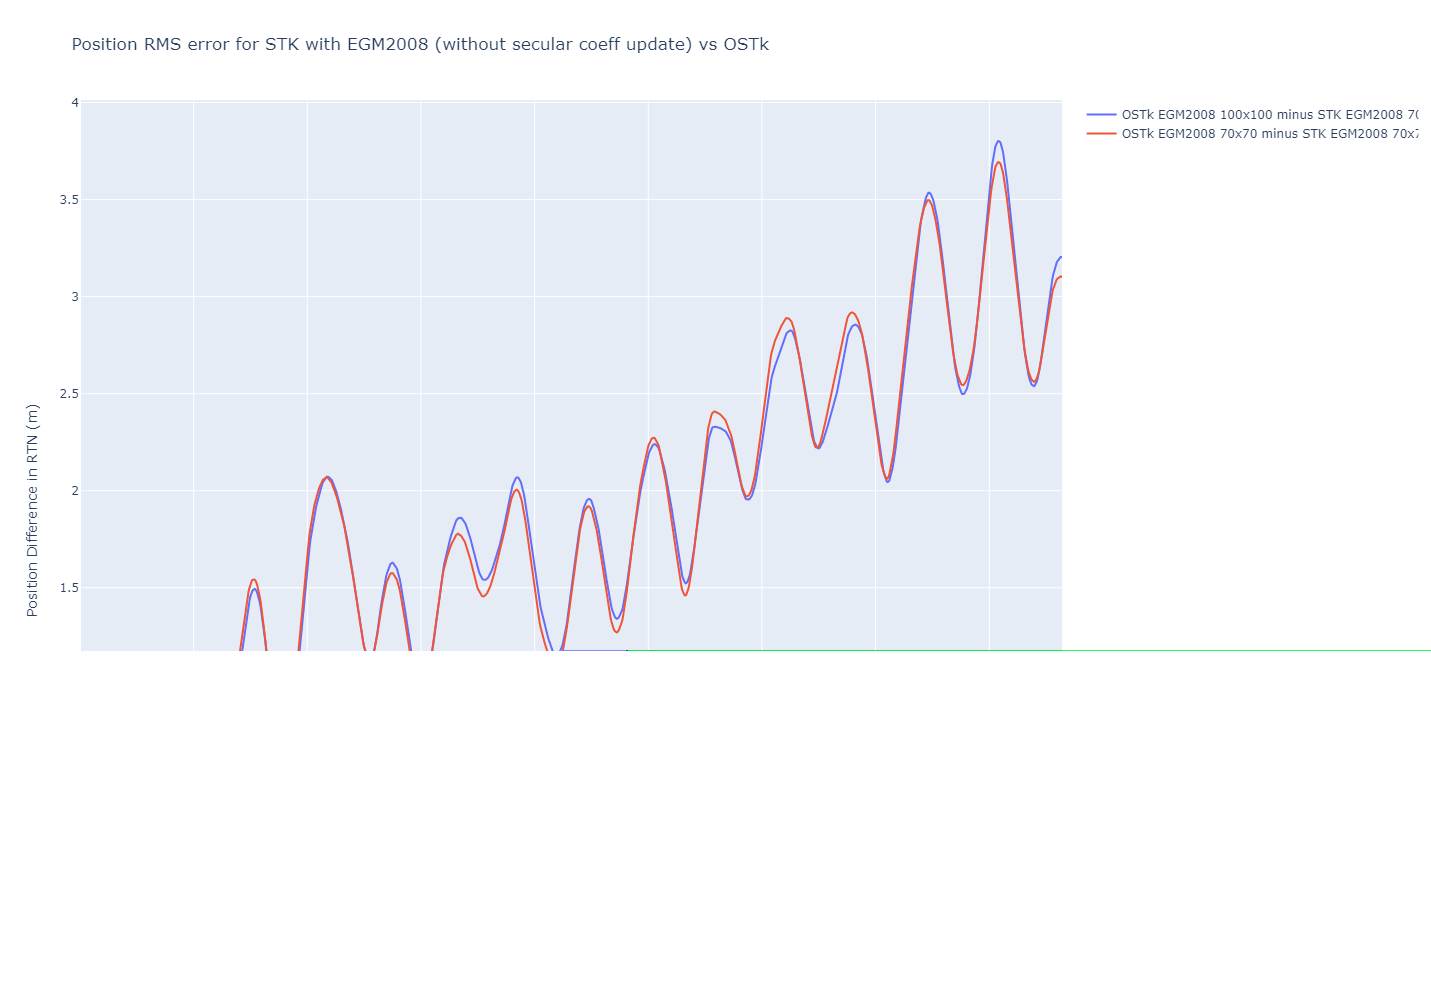

In [348]:
orbit_df_RMS_position_list = [
    orbit_df_RMS_list[list_ind][["Elapsed secs", "${\delta}x$"]]
    for list_ind in range(0, len(orbit_list))
]

figure = go.Figure()
figure.update_layout(
    title=f"Position {plot_title_extension}", showlegend=True, height=1000
)
figure.update_xaxes(title_text="Time Elapsed (s)")
figure.update_yaxes(title_text="Position Difference in RTN (m)")

for list_ind, orbit_df_RMS_position in enumerate(orbit_df_RMS_position_list):
    figure.add_trace(
        go.Scatter(
            x=orbit_df_RMS_position["Elapsed secs"],
            y=orbit_df_RMS_position["${\delta}x$"],
            name=legend_name_list[list_ind],
            mode="lines",
        )
    )

figure.show()

Plot velocity error

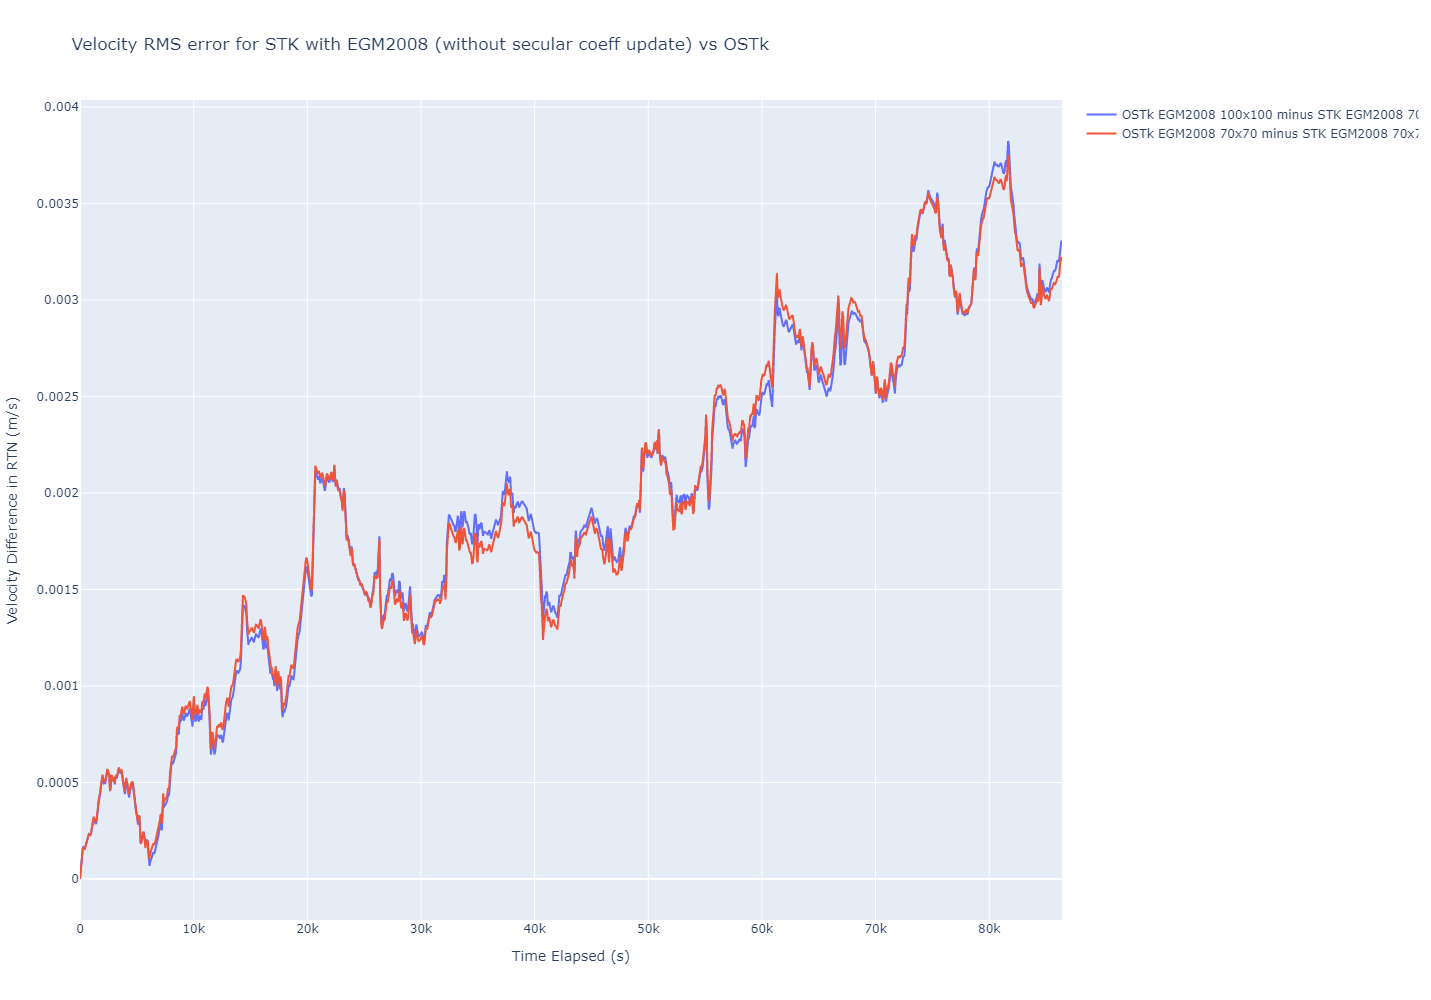

In [349]:
orbit_df_RMS_velocity_list = [
    orbit_df_RMS_list[list_ind][["Elapsed secs", "${\delta}v$"]]
    for list_ind in range(0, len(orbit_list))
]

figure = go.Figure()
figure.update_layout(
    title=f"Velocity {plot_title_extension}", showlegend=True, height=1000
)
figure.update_xaxes(title_text="Time Elapsed (s)")
figure.update_yaxes(title_text="Velocity Difference in RTN (m/s)")

for list_ind, orbit_df_RMS_velocity in enumerate(orbit_df_RMS_velocity_list):
    figure.add_trace(
        go.Scatter(
            x=orbit_df_RMS_velocity["Elapsed secs"],
            y=orbit_df_RMS_velocity["${\delta}v$"],
            name=legend_name_list[list_ind],
            mode="lines",
        )
    )

figure.show()